Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)

Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.094293 s


'compile' took 0.978213 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.31e-03, 4.56e-01, 1.07e-01, 7.83e-04]    [3.31e-03, 4.56e-01, 1.07e-01, 7.83e-04]    []  
1000      [1.87e-03, 2.81e-03, 1.12e-02, 8.55e-04]    [1.87e-03, 2.81e-03, 1.12e-02, 8.55e-04]    []  
2000      [1.48e-03, 8.86e-04, 5.70e-03, 2.21e-04]    [1.48e-03, 8.86e-04, 5.70e-03, 2.21e-04]    []  
3000      [9.32e-04, 5.45e-04, 3.73e-03, 

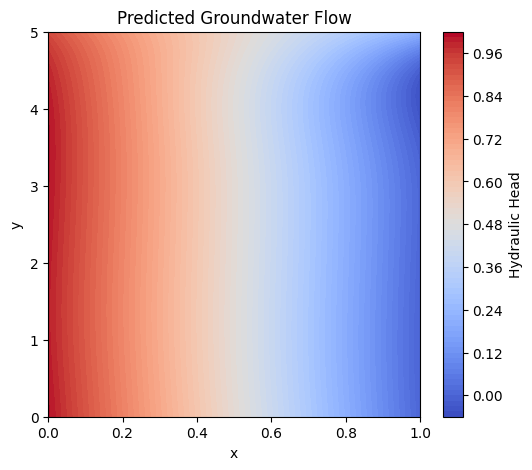

In [5]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the variable bedrock depth function
def bedrock_depth(x):
    """Defines a variable bedrock depth profile."""
    return 5 + 2 * np.sin(np.pi * x)  # Example sinusoidal bedrock depth

# Define the PDE: Laplace's equation ∇²h = 0
def pde(x, h):
    d2h_dx2 = dde.grad.hessian(h, x, i=0, j=0)
    d2h_dy2 = dde.grad.hessian(h, x, i=1, j=1)
    return d2h_dx2 + d2h_dy2  # Laplace equation

# Define domain: X = 0 to 1, Y = 0 to bedrock_depth(X)
geom = dde.geometry.Rectangle([0, 0], [1, 5])  # Bounding box

# Define Dirichlet boundary conditions (fixed head)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_left = dde.DirichletBC(geom, lambda x: 1, boundary_left)  # Head = 1 on left
bc_right = dde.DirichletBC(geom, lambda x: 0, boundary_right)  # Head = 0 on right

# Define Neumann BC (no-flow at variable bedrock depth)
def bedrock(x, on_boundary):
    return on_boundary and np.isclose(x[1], bedrock_depth(x[0]))

bc_bedrock = dde.NeumannBC(geom, lambda x: 0, bedrock)  # No-flow at bedrock

# Define dataset
data = dde.data.PDE(geom, pde, [bc_left, bc_right, bc_bedrock], num_domain=1000, num_boundary=200)

# Define neural network
net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Define the PINN model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate predictions for visualization
x_test = np.linspace(0, 1, 100)
y_test = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x_test, y_test)
XY = np.vstack((X.flatten(), Y.flatten())).T
h_pred = model.predict(XY).reshape(X.shape)

# Plot results
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, h_pred, cmap="coolwarm", levels=100)
plt.colorbar(label="Hydraulic Head")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Groundwater Flow")
plt.show()
